

We analyze the effects of Alpenglow and SIMD-228 on validator profitability and distribution. We use Helius' dataset on all Solana Validators in data/validator_profit.csv. To begin, we'll look at the dataset and analyze the status quo with no Alpenglow or SIMD-228.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pygal


from IPython.display import SVG, display
import sys

sys.path.append('../')

from scripts.utils import *
from scripts.linebar import LineBar
s_quo = pd.read_csv('../data/validator_profit.csv')
s_quo.head()


,Rank,Validator Name,Validator Vote Account,Active Stake (SOL),Percentage of total stake (%),Cumulative Stake (%),Issuance Rewards Commission (%),Jito MEV Commission Rate (%),Issuance Revenue (SOL),Issuance Revenue as % of Total Revenue (%),Jito MEV Revenue (SOL),Jito MEV Revenue as % of Total Revenue (%),Block Rewards Revenue (SOL),Block Rewards Revenue as % of Total Revenue (%),Total Revenue (SOL),Server Cost (SOL),Voting Cost (SOL),Profit(SOL),Profitable
0,1,Helius,he1iusunGwqrNtafDtLdhsUQDFvo13z9sUa36PauBtk,13356080.98,0.03554,0.036,0.00,0.00,0.00,0.0000,0.00,0.0000,174465.76,1.0000,174465.76,133.33,365,173967.42,YES
1,2,Binance Staking,3N7s9zXMZ4QqvHQR15t5GNHyqc89KduzMP7423eWiD5g,11506125.17,0.03062,0.066,0.08,0.10,63261.34,0.2758,15821.10,0.0690,150300.44,0.6552,229382.88,133.33,365,228884.55,YES
2,3,Coinbase 02,6D2jqw9hyVCpppZexquxa74Fn33rJzzBx38T58VucHx9,10022736.57,0.02667,0.093,0.08,0.08,55105.59,0.2796,11025.13,0.0559,130923.46,0.6644,197054.18,133.33,365,196555.85,YES
3,4,Galaxy,CvSb7wdQAFpHuSpTYTJnX5SYH4hCfQ9VuGnqrKaKwycB,8975929.50,0.02389,0.117,0.05,0.25,30843.86,0.1724,30855.10,0.1724,117249.39,0.6552,178948.35,133.33,365,178450.02,YES
4,5,Ledger by Figment,26pV97Ce83ZQ6Kz9XT4td8tdoUFPTng8Fb8gPyc53dJx,8567673.97,0.02280,0.140,0.07,0.07,41217.37,0.2554,8246.48,0.0511,111916.49,0.6935,161380.34,133.33,365,160882.01,YES


## stake distribution analysis

we bin validators by their active stake amounts to understand the distribution of stake across the network. this shows both the number of validators in each stake range and the total stake concentration.


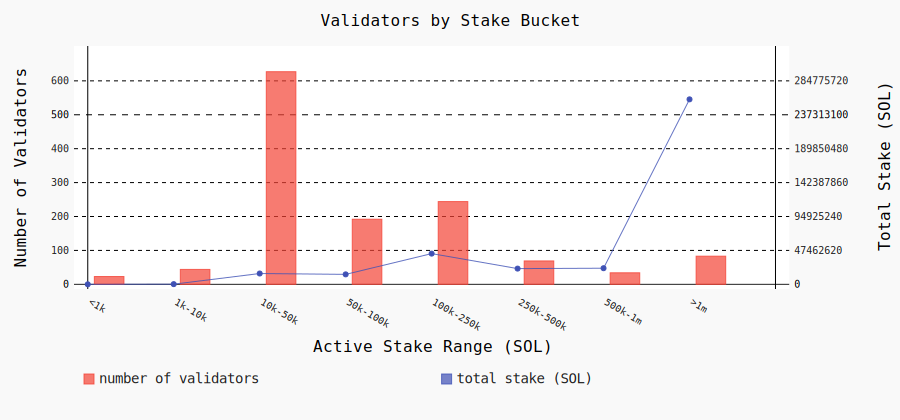

In [2]:
# --- stake distribution chart ---
chart = create_stake_distribution_chart(s_quo, "Validators by Stake Bucket")
display(SVG(chart.render()))

## revenue composition analysis

we analyze how validator revenues are composed of different sources: transaction fees, MEV revenue, and issuance rewards. comparing top and bottom performers shows the revenue distribution inequality.


In [3]:
# create standardized chart style
custom_style = get_custom_chart_style()

### bottom performer revenue breakdown

examining the lowest revenue validators shows the stark contrast in earnings and highlights validators that may struggle with profitability under current conditions.


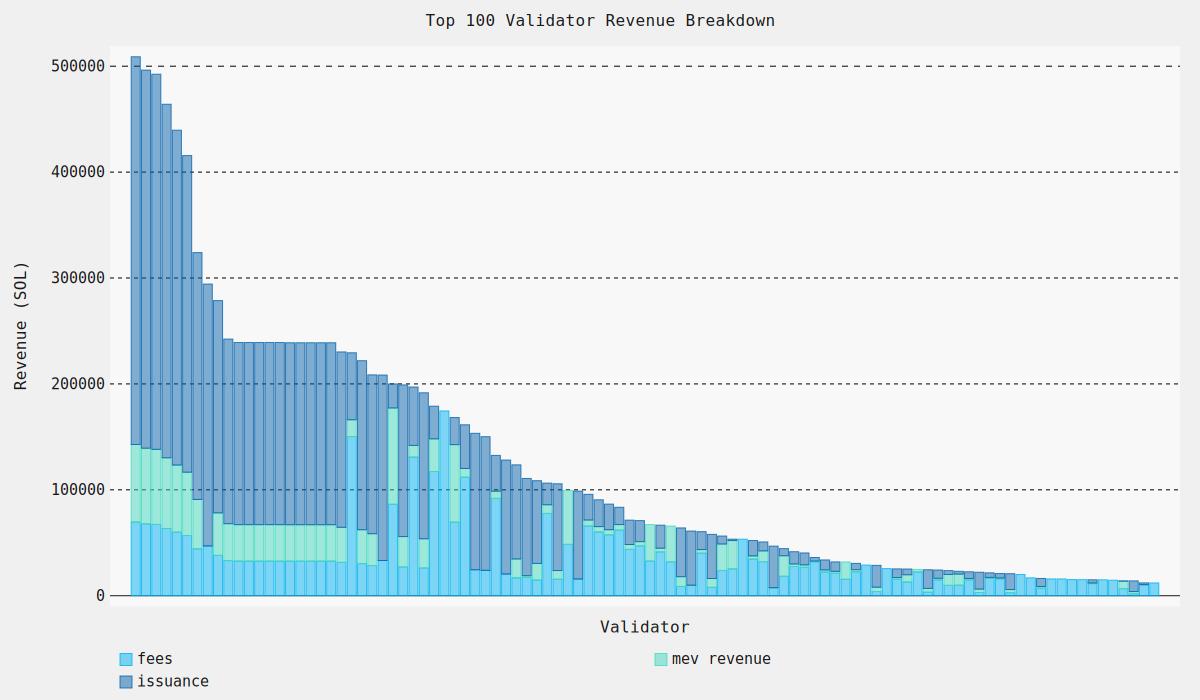

In [4]:
# --- top 100 validator revenue breakdown ---
chart = create_revenue_breakdown_chart(s_quo, top_n=100, title_prefix="Top")
display(SVG(chart.render()))

## inequality metrics vs inflation

we examine how the gini coefficient (measure of inequality) changes with different inflation rates. this helps understand the relationship between network inflation and validator income distribution.


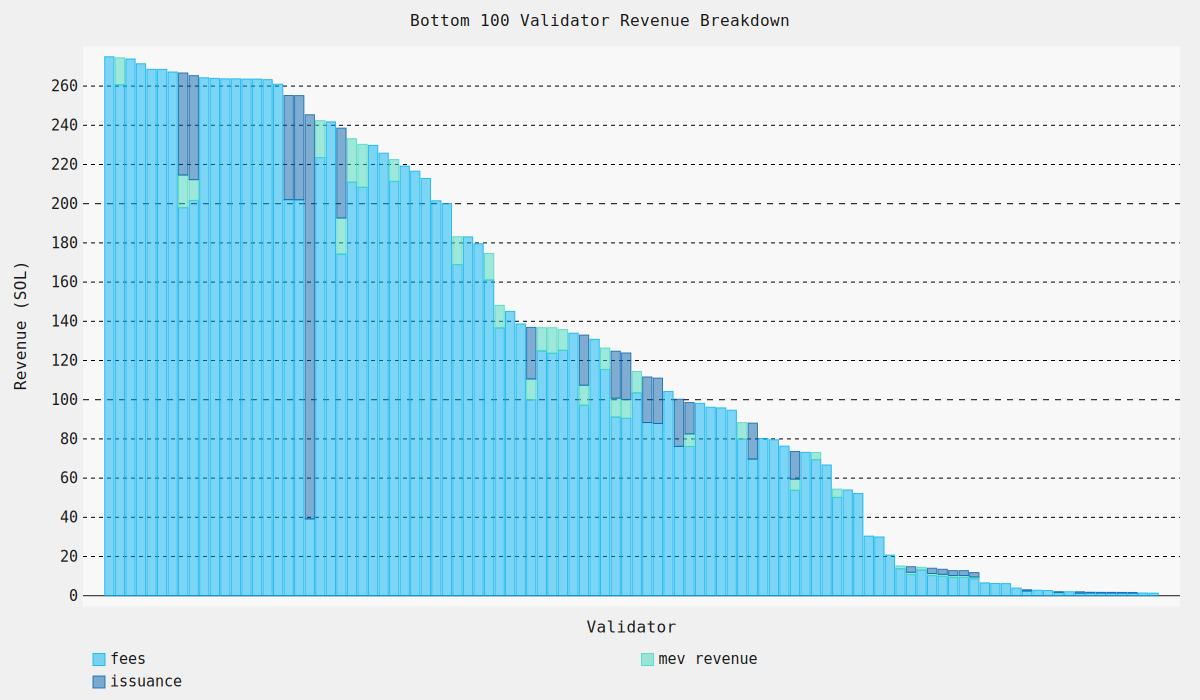

In [5]:
# --- bottom 100 validator revenue breakdown ---
chart_bottom = create_revenue_breakdown_chart(s_quo, top_n=100, title_prefix="Bottom")
display(SVG(chart_bottom.render()))

## validator profitability distribution

we analyze the current profit distribution across validators by stake size, calculating key inequality metrics including the gini coefficient and shannon entropy to quantify concentration.


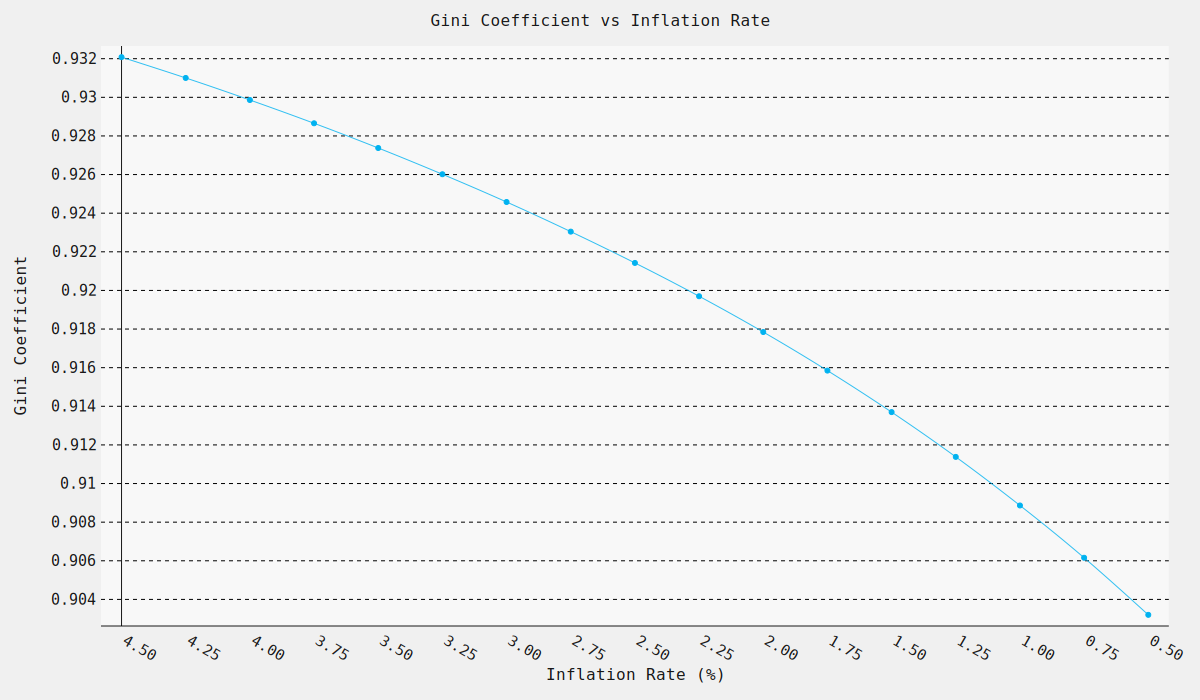

In [6]:
# --- gini coefficient vs inflation rate ---
line_chart = create_gini_inflation_chart(s_quo)
display(SVG(line_chart.render()))

## alpenglow scenario analysis

we compare the status quo against a scenario where validators have zero voting costs (simulating alpenglow's effect). this shows how reducing operational costs affects validator profitability across different stake percentiles.


/Users/mustafaqazi/research/alpenglow_validator_analysis/notebooks/../scripts/utils.py:155: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('stake_bucket')['Profit(SOL)']


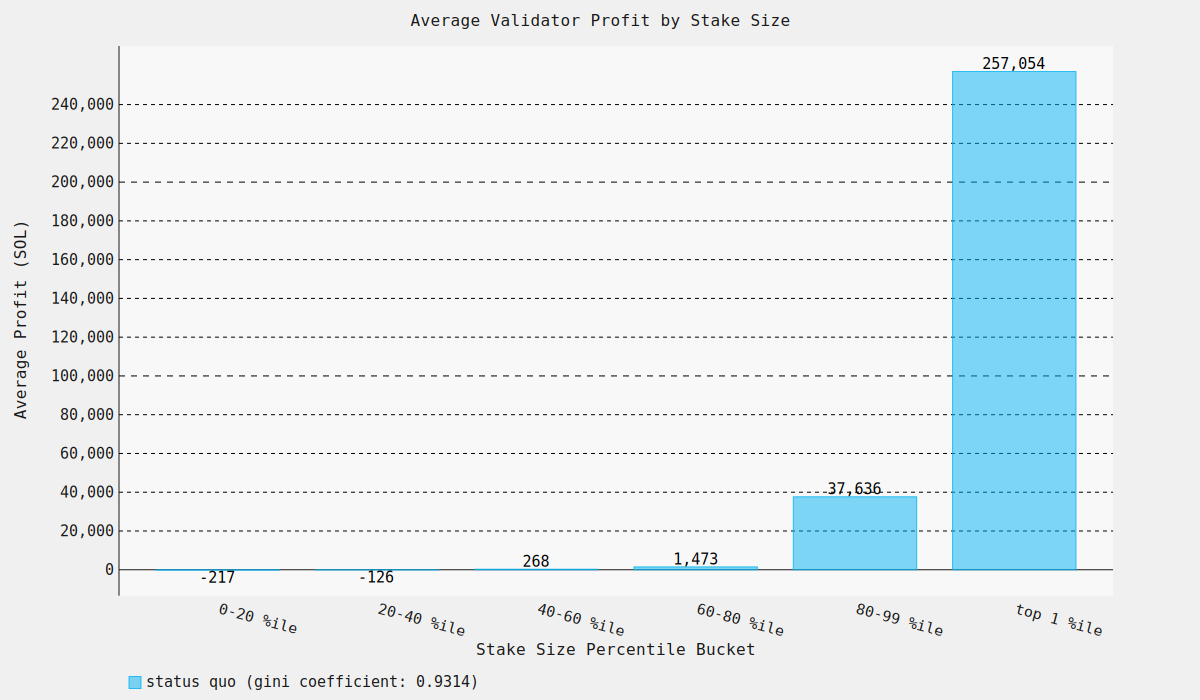

Gini Coefficient: 0.93
Shannon Entropy: 0.64


In [7]:
# --- status quo profit distribution ---
s_quo_local = s_quo.copy()
chart = profit_distribution_chart(s_quo_local, 'Average Validator Profit by Stake Size')
display(SVG(chart.render()))

gini = calc_modified_gini(s_quo_local)
shannon = calc_shannon_entropy(s_quo_local)
print(f"Gini Coefficient: {gini:.2f}")
print(f"Shannon Entropy: {shannon:.2f}")

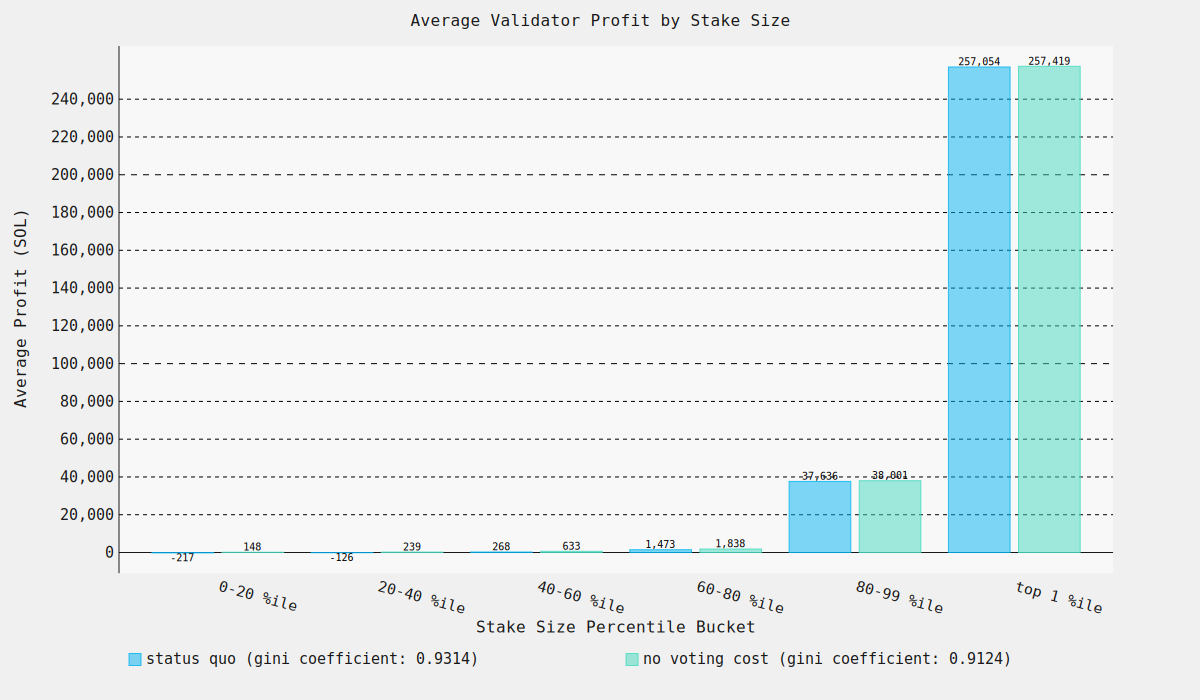

In [8]:
# --- alpenglow scenario comparison ---
alpenglow_no_vote = change_vote_fees(s_quo.copy(), 0)
alpenglow_no_vote = recompute_profits(alpenglow_no_vote)

# calculate gini coefficients
s_quo_gini = calc_modified_gini(s_quo)
alpenglow_gini = calc_modified_gini(alpenglow_no_vote)

scenarios = [s_quo, alpenglow_no_vote]
scenario_labels = [
    f'status quo (gini coefficient: {s_quo_gini:.4f})',
    f'no voting cost (gini coefficient: {alpenglow_gini:.4f})'
]

chart = create_profit_comparison_chart(scenarios, scenario_labels)
display(SVG(chart.render()))

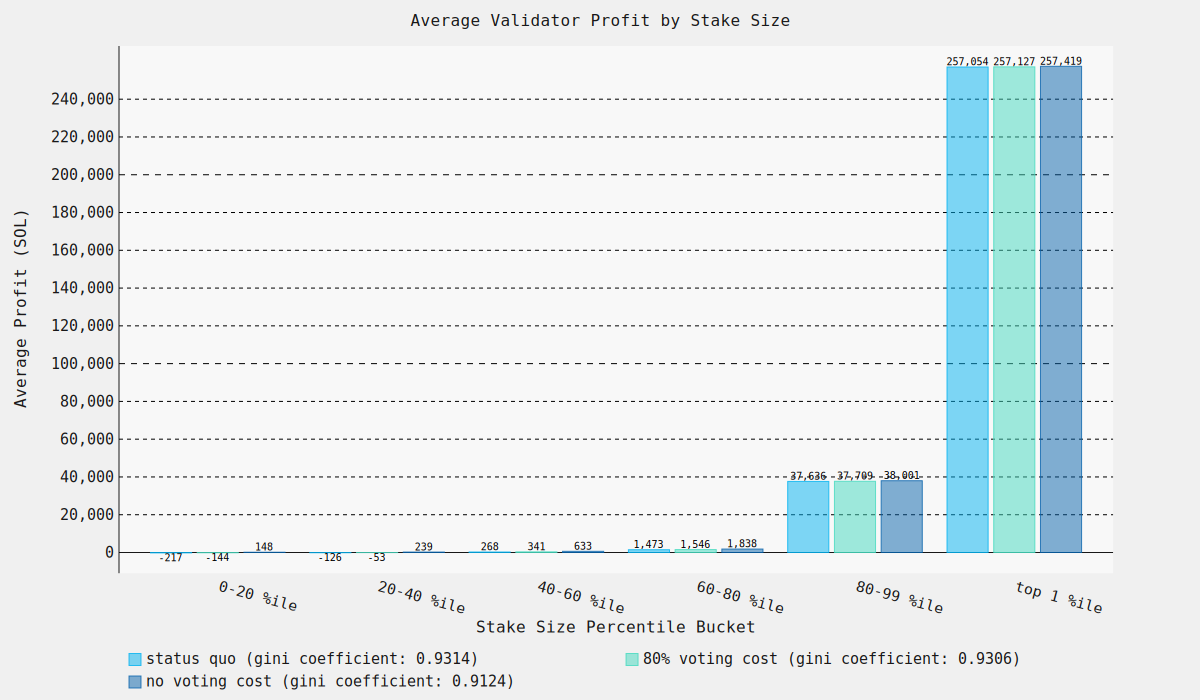

In [9]:
# --- three scenario comparison (status quo, 80% vote, no vote) ---
eighty_vote = recompute_profits(change_vote_fees(s_quo.copy(), 0.8))

# calculate gini coefficients
s_quo_gini = calc_modified_gini(s_quo)
eighty_vote_gini = calc_modified_gini(eighty_vote)
alpenglow_gini = calc_modified_gini(alpenglow_no_vote)

scenarios = [s_quo, eighty_vote, alpenglow_no_vote]
scenario_labels = [
    f'status quo (gini coefficient: {s_quo_gini:.4f})',
    f'80% voting cost (gini coefficient: {eighty_vote_gini:.4f})',
    f'no voting cost (gini coefficient: {alpenglow_gini:.4f})'
]

chart = create_profit_comparison_chart(scenarios, scenario_labels)
display(SVG(chart.render()))

In [10]:
# --- simd228 scenarios with 0.135 VAT ---
df = load_and_clean_data('../data/validator_profit.csv')

low_stake = recompute_profits(apply_simd228(change_vote_fees(df, 0.135), 0.4, 0.02))
med_stake = recompute_profits(apply_simd228(change_vote_fees(df, 0.135), 0.6, 0.02))  
high_stake = recompute_profits(apply_simd228(change_vote_fees(df, 0.135), 0.85, 0.02))

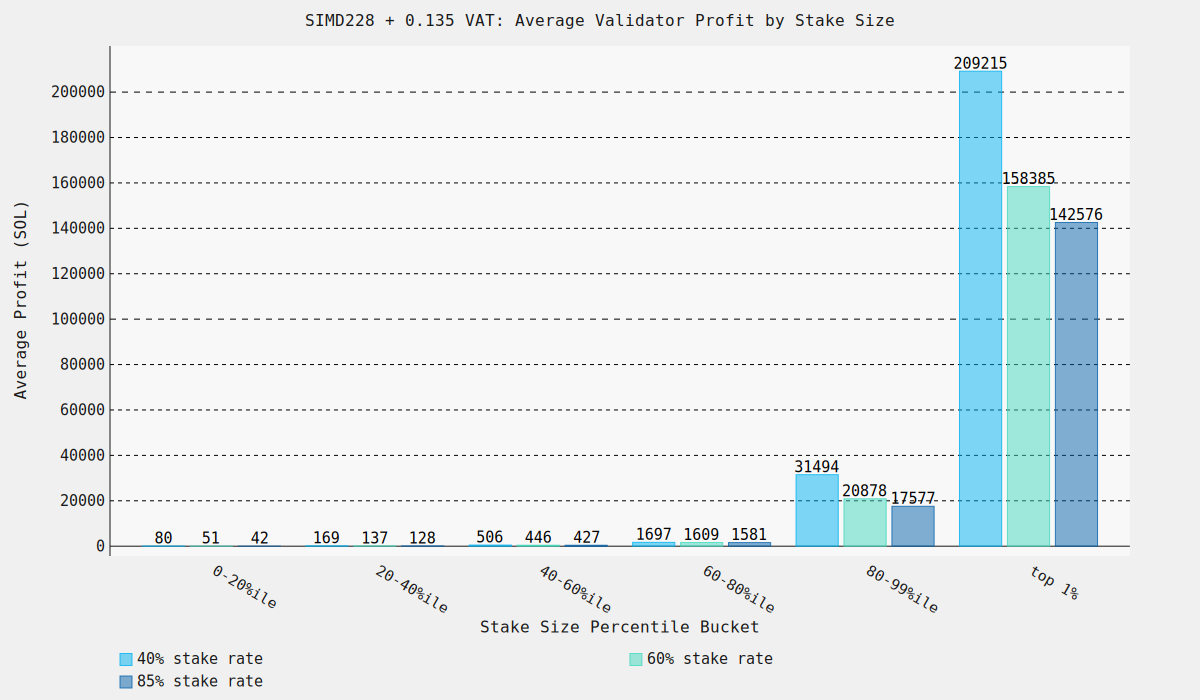

gini coefficient for low stake regime profit: 0.9082
shannon entropy for low stake regime profit: 0.6738
gini coefficient for medium stake regime profit: 0.8884
shannon entropy for medium stake regime profit: 0.7047
gini coefficient for high stake regime profit: 0.8793
shannon entropy for high stake regime profit: 0.7167


In [11]:
# --- simd228 + 0.135 VAT chart ---
scenarios = [low_stake, med_stake, high_stake]
scenario_labels = ['40% stake rate', '60% stake rate', '85% stake rate']

chart = create_simd228_chart(
    scenarios, 
    scenario_labels, 
    'SIMD228 + 0.135 VAT: Average Validator Profit by Stake Size'
)
display(SVG(chart.render()))

# calculate and print metrics for each scenario
for stake_data, label in zip([low_stake, med_stake, high_stake], ['low', 'medium', 'high']):
    gini = calc_modified_gini(stake_data)
    shannon = calc_shannon_entropy(stake_data) 
    print(f'gini coefficient for {label} stake regime profit: {gini:.4f}')
    print(f'shannon entropy for {label} stake regime profit: {shannon:.4f}')

In [12]:
# --- alpenglow + simd228 scenarios (80% vote cost) ---
s_quo_local = s_quo.copy()

alp_low_stake = recompute_profits(apply_simd228(change_vote_fees(s_quo_local, 0.8), 0.4))
alp_med_stake = recompute_profits(apply_simd228(change_vote_fees(s_quo_local, 0.8), 0.6))
alp_high_stake = recompute_profits(apply_simd228(change_vote_fees(s_quo_local, 0.8), 0.85))

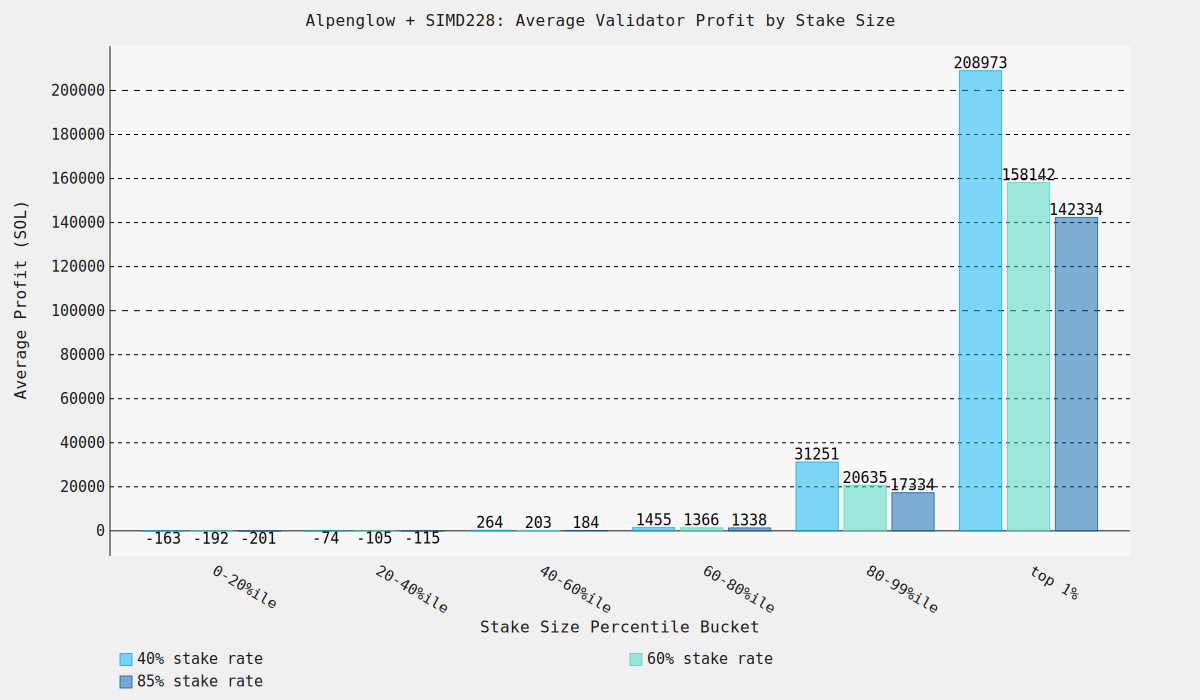

gini coefficient for alpenglow+simd228 low stake regime profit: 0.9240
shannon entropy for alpenglow+simd228 low stake regime profit: 0.6583
gini coefficient for alpenglow+simd228 medium stake regime profit: 0.9078
shannon entropy for alpenglow+simd228 medium stake regime profit: 0.6860
gini coefficient for alpenglow+simd228 high stake regime profit: 0.9003
shannon entropy for alpenglow+simd228 high stake regime profit: 0.6966


In [13]:
# --- alpenglow + simd228 chart ---
scenarios = [alp_low_stake, alp_med_stake, alp_high_stake]
scenario_labels = ['40% stake rate', '60% stake rate', '85% stake rate']

chart = create_simd228_chart(
    scenarios,
    scenario_labels, 
    'Alpenglow + SIMD228: Average Validator Profit by Stake Size'
)
display(SVG(chart.render()))

# calculate and print metrics for alpenglow+simd228 scenarios
for stake_data, label in zip([alp_low_stake, alp_med_stake, alp_high_stake], ['low', 'medium', 'high']):
    gini = calc_modified_gini(stake_data)
    shannon = calc_shannon_entropy(stake_data)
    print(f'gini coefficient for alpenglow+simd228 {label} stake regime profit: {gini:.4f}')
    print(f'shannon entropy for alpenglow+simd228 {label} stake regime profit: {shannon:.4f}')